In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 
import time

import matplotlib.pyplot as plt 
import seaborn as sns 

import json
from datetime import datetime
import os
import re

In [2]:
def find_last_submission_number(directory = '.'):
    """
    Находит последний номер сабмишена в указанной директории.
    
    Параметры:
        directory (str): Путь к директории с файлами сабмишенов. По дефолту текущая папка.
    
    Возвращает:
        int: Последний номер сабмишена или 0, если файлы не найдены.
    """
    regex = re.compile(r"Babaev_submission_(\d+)\.csv")
    files = os.listdir(directory)
    numbers = [int(regex.search(file).group(1)) for file in files if regex.search(file)]
    return max(numbers) if numbers else 0


last_sub__number = find_last_submission_number()
print(f'Last submission number : {last_sub__number}')

Last submission number : 15


In [3]:
submission_num = last_sub__number + 1

# Пайплайн

Исходные датасеты были почищены от нанов, были исключены колонки с большим содержанием null, добавлены фичи завязанные на времени покупки и сагрегированные фичи на основе некоторых признаков. А также произведен энкодинг категориальных фич. 

Подробнее об этом в файле <span style="color: green;">Babaev_HW4_eda_preprocessing.ipynb</span>. Результаты были с сохранены в parquet файлы ***_pr.parquet**

In [4]:
train_df = pd.read_parquet("train_pr.parquet")
test_df = pd.read_parquet("test_pr.parquet")

Продемонстрируем изменения которые произошли

In [5]:
df_train_origin = pd.read_parquet("train.parquet")

columns_train = set(train_df.columns)
columns_origin = set(df_train_origin.columns)

# Определим изменения в колонках
added_columns = columns_train - columns_origin
removed_columns = columns_origin - columns_train

# Определим изменения в типах данных
changed_data_types = {
    column: (df_train_origin.dtypes[column], train_df.dtypes[column])
    for column in (columns_train & columns_origin) 
    if df_train_origin.dtypes[column] != train_df.dtypes[column]
}

print("Added Columns:", added_columns)
print("Removed Columns:", removed_columns)
print("Changed Data Types:", changed_data_types)

Added Columns: {'visitHour', 'totals_bounces_sum', 'totals_pageviews_median', 'totals_bounces_median', 'month', 'totals_hits_min', 'totals_newVisits_mean', 'year', 'totals_hits_sum', 'day', 'totals_hits_median', 'totals_pageviews_mean', 'date_min', 'date_max', 'totals_newVisits_sum', 'totals_newVisits_median', 'totals_pageviews_max', 'totals_pageviews_sum', 'weekday', 'totals_hits_max', 'totals_hits_mean', 'totals_bounces_mean', 'totals_pageviews_min'}
Removed Columns: {'trafficSource_keyword', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_referralPath', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.slot'}
Changed Data Types: {'device_browser': (dtype('O'), dtype('int64')), 'totals_transactionRevenue': (dtype('float32'), dtype('float64')), 'trafficSource_medium': (dtype('O'), dtype('int64')), 'device_deviceCategory': (dtype('O'), dtype('int64')), 'totals_newVisits': (dtype('O'),

Подгрузим категориальные фичи

In [6]:
with open('cat_features.json', 'r') as file:
    cat_features = json.load(file)

# Организация обучения и валидации (6 баллов)

###  Подходы к задаче (8 баллов). Подход №1. LGBM + KFold + CV

#### Работа с целевой метрикой (5 баллов). Создание кастомной objective function

Для передачи нашего кастомного ассиметричного MSLE в lgbm, необходимо предварительно посчитать градиент и гессиан

MSLE для предсказанного значения $ y $ и фактического значения $\hat{y}$:
$\text{MSLE} = (\log(1 + y) - \log(1 + \hat{y}))^2$

Где ошибка $\text{res}$ определяется как:
$res = \log(1 + y) - \log(1 + \hat{y})$

$\text{Асимметричная MSLE} = 
\begin{cases} 
\text{res}^2 & \text{если } \text{res} \geq 0 \\
1.2 \times \text{res}^2 & \text{если } \text{res} < 0 
\end{cases}
$

Градиент MSLE по предсказанному значению $ {y} $:

$ \frac{\partial \text{res}}{\partial {y}} = 2 \left(\log(1 + y) - \log(1 + \hat{y})\right) \cdot \frac{1}{1 + {y}} $

Это упрощается до:
$ \nabla = 2 \cdot \text{res} \cdot \frac{1}{1 + {y}} $

Для асимметричной MSLE:
$ \nabla_{as} = 
\begin{cases} 
2 \cdot \text{res} \cdot \frac{1}{1 + {y}} & \text{если } \text{res} \geq 0 \\
2.4 \cdot \text{res} \cdot \frac{1}{1 + {y}} & \text{если } \text{res} < 0 
\end{cases}
$

Гессиан для MSLE по $ {y} $:

$ \frac{d^2 \text{res}}{d {y}^2} =  \frac{-2 \cdot \ln(y+1) + 2 \cdot \ln(\hat{y}+1) + 2}{(y + 1)^2} = \frac{-2 \text{res} + 2}{(y + 1)^2}$

$ H = 
\begin{cases} 
(-2) \cdot \frac{\text{res} - 1}{(1 + {y})^2} & \text{если } \text{res} \geq 0 \\
(-2.4) \cdot \frac{\text{res} - 1}{(1 + {y})^2} & \text{если } \text{res} < 0 
\end{cases}
$

In [7]:
from utils_main import asymmetric_msle_objective, asymmetric_msle_eval, asymmetric_msle_score
from sklearn.model_selection import KFold
import lightgbm as lgb

Поменяем objective function на кастомную,а в качестве метрики укажем None, так как метрика будет оцениваться через кастомизированную функцию ошибки.

In [8]:
param = {'num_leaves': 300,
         'min_data_in_leaf': 30, 
         'objective': asymmetric_msle_objective,
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": None,
         "lambda_l1": 1,
         "verbosity": -1}

Зададим таргет и исключим колонки с датами и ключевыми значениями (типо fullVisitorId)

In [9]:
target = train_df['totals_transactionRevenue'].astype(float)
specific_cols = ['fullVisitorId', 'sessionId', 'date', 'date_min', 'date_max', 'totals_transactionRevenue', 'visitId']
trn_cols = [col for col in train_df.columns if col not in specific_cols]

Реализуем разбиение на 5 фолдов и кросс-валидацию. Обучим модель используя LGBM.

In [10]:
from utils_main import train_and_visualize

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's asymmetric_msle: 4.33451	valid_1's asymmetric_msle: 4.31432
[200]	training's asymmetric_msle: 4.15548	valid_1's asymmetric_msle: 4.15119
[300]	training's asymmetric_msle: 3.99386	valid_1's asymmetric_msle: 4.00556
[400]	training's asymmetric_msle: 3.84865	valid_1's asymmetric_msle: 3.87676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further split

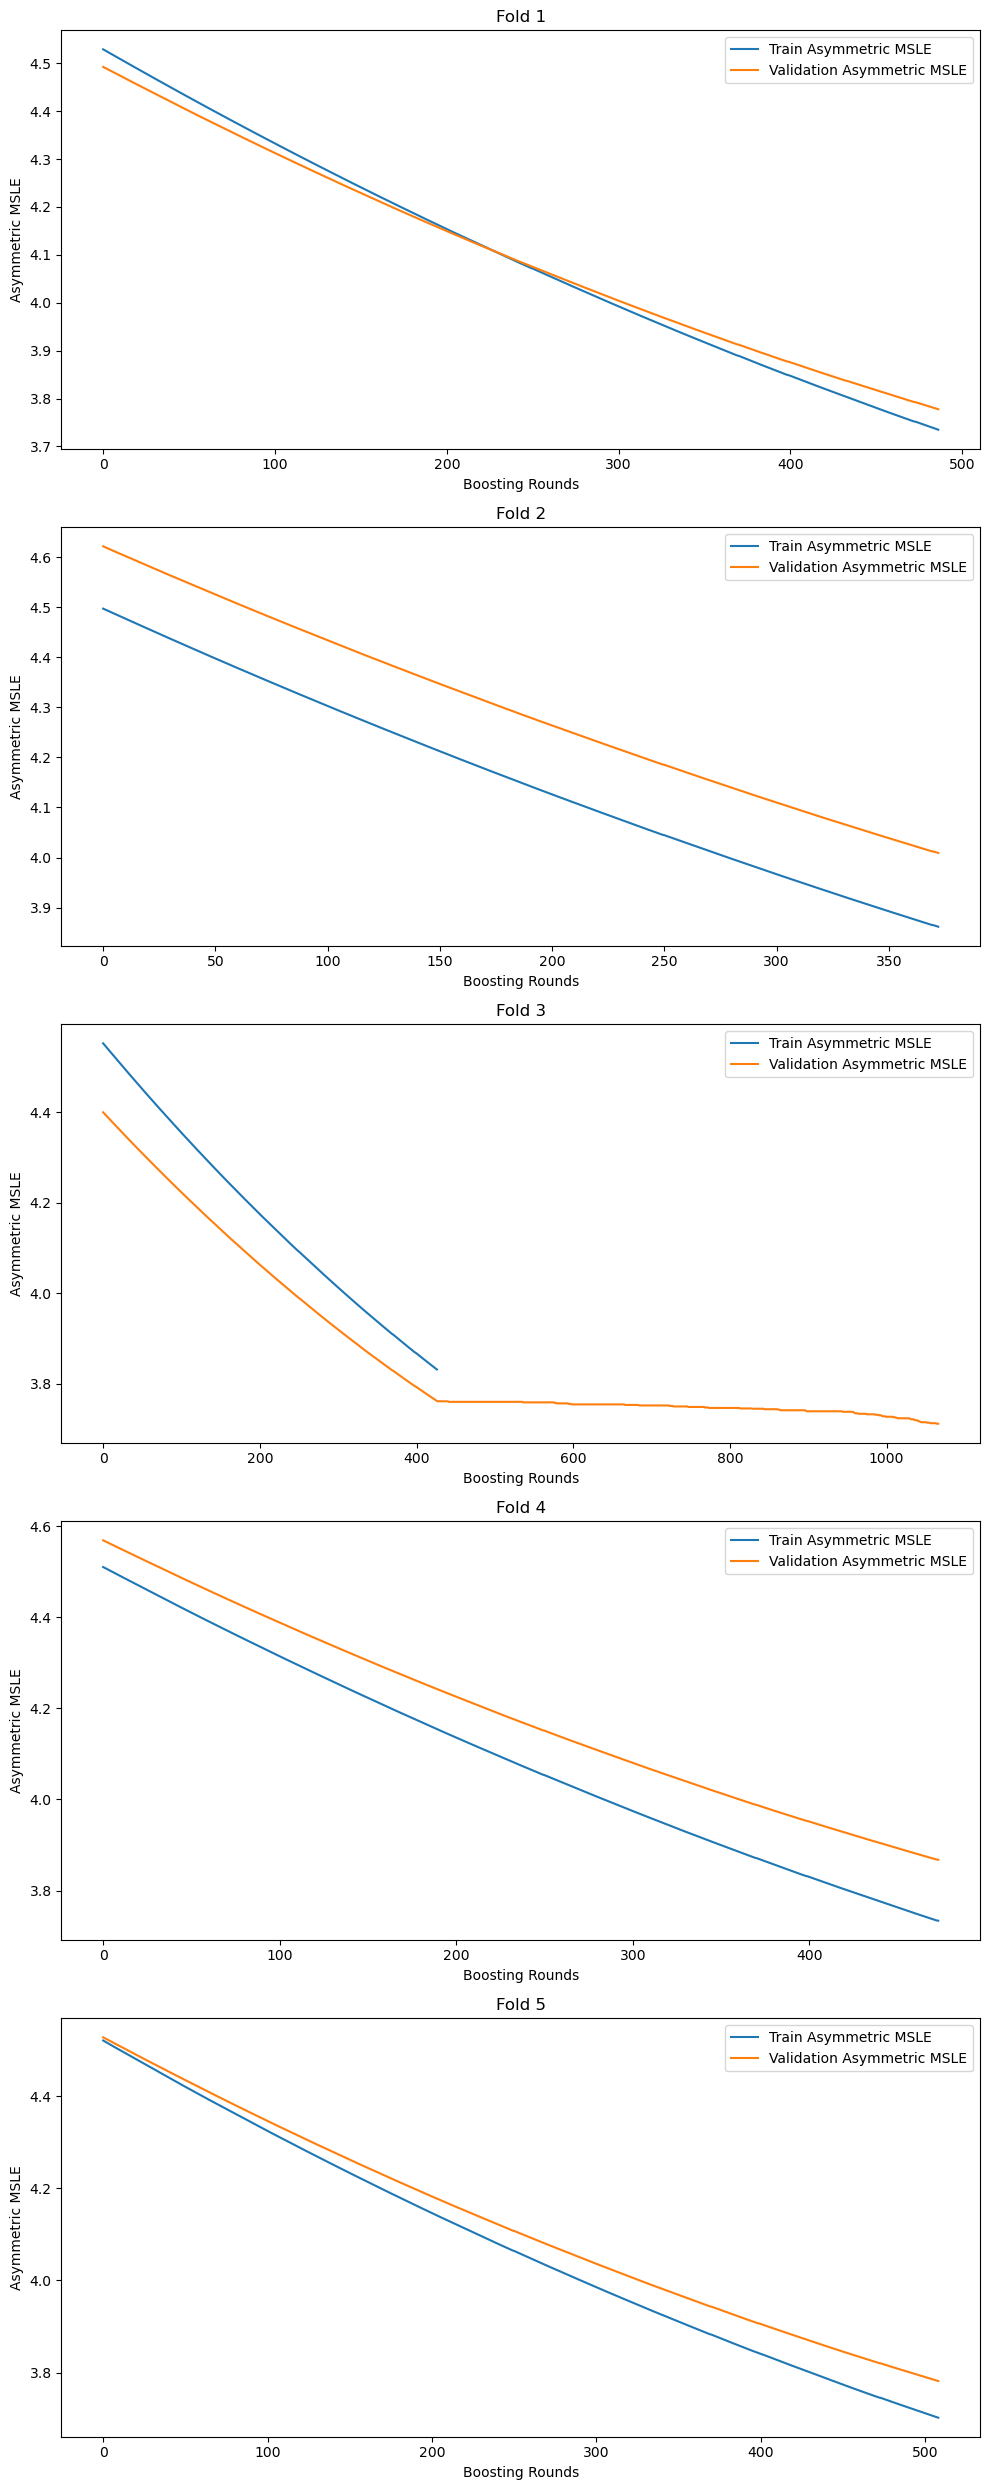

Training completed in 429.89069533348083 seconds.


In [11]:
oof, predictions, feature_importance_df = train_and_visualize(train_df, test_df, trn_cols, target, cat_features, param)

Fold 1, 2, 5:
Обе кривые уменьшаются относительно стабильно и сходятся, что указывает на хорошее соответствие модели без значительного переобучения.

Fold 3:
Валидационная ошибка уменьшается и стабилизируется после примерно 400 итераций, в то время как ошибка обучения продолжает уменьшаться, показывая разрыв между двумя кривыми. Это может указывать на некоторое переобучение.

Fold 4:
Существенное расхождение между тренировочной и валидационной ошибками начинается с ранних стадий и сохраняется, что указывает на наличие переобучения, особенно заметное после 200 итерации.

In [12]:
print("CV score: {:<8.5f}".format(asymmetric_msle_score(oof, target)))

CV score: 3.82731 


Посмотри на фича импортанс

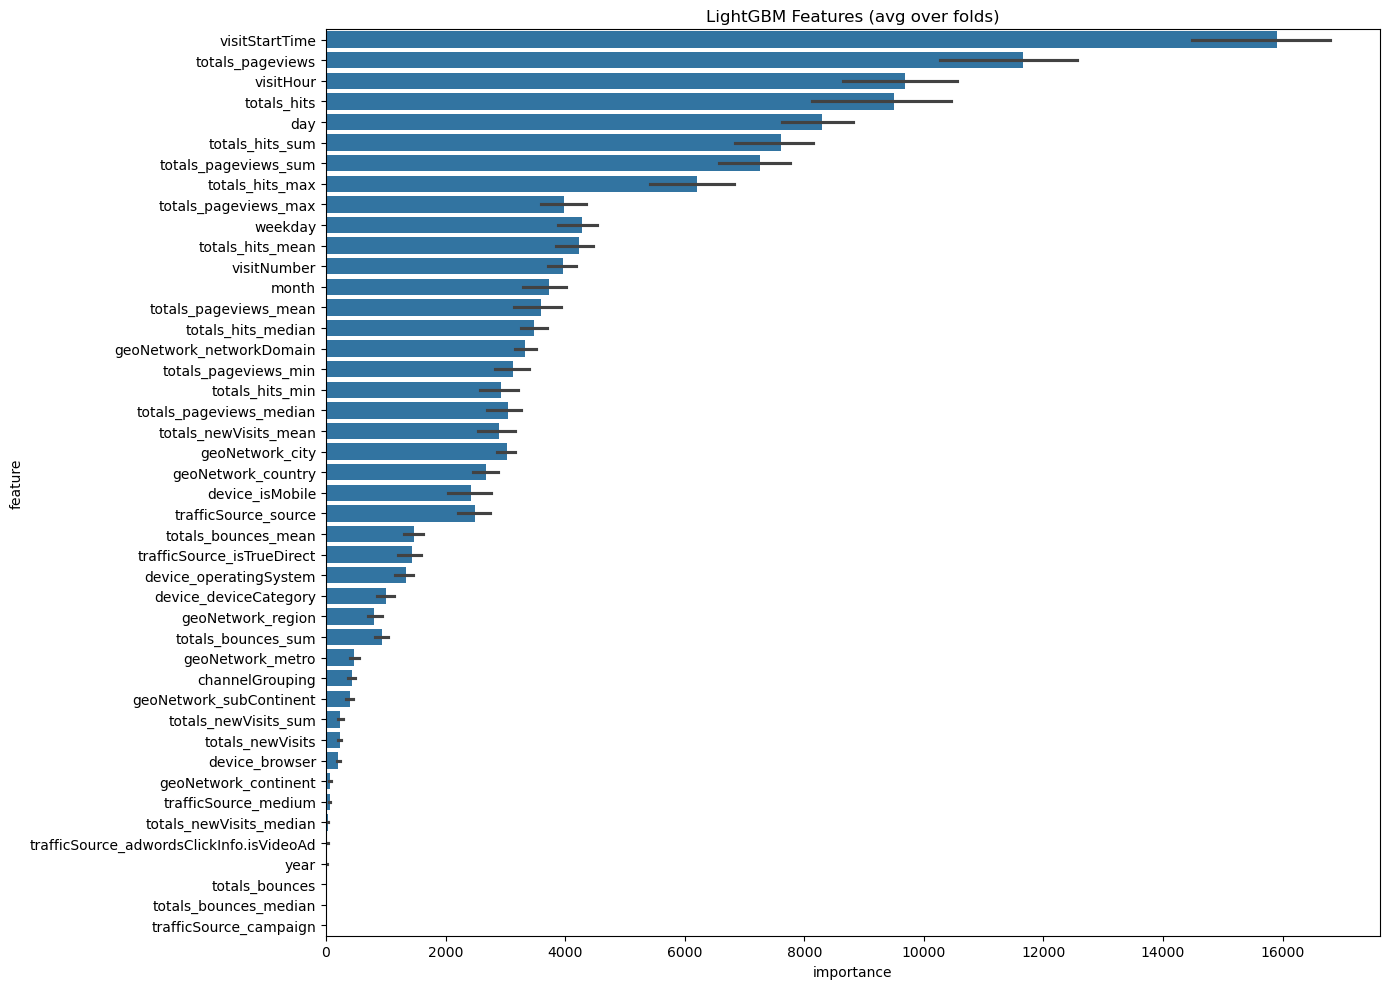

In [13]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:1000].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [13]:
ss = pd.read_csv("sample_submission.csv").drop(columns='target')

In [18]:
submission = test_df[['fullVisitorId']].copy()
submission.loc[:, 'target'] = predictions
grouped_test = submission[['fullVisitorId', 'target']].groupby('fullVisitorId').mean().reset_index()

Определим для каждого ли юзера в тестовом датафрейме есть соответствующий в сабмишене

In [15]:
set_grouped_test = set(grouped_test['fullVisitorId'].astype(str))
set_ss = set(ss['fullVisitorId'].astype(str))

unique_to_ss = set_ss.difference(set_grouped_test)
unique_to_grouped_test = set_grouped_test.difference(set_ss)

df_unique_to_ss = pd.DataFrame(list(unique_to_ss), columns=['fullVisitorId'])
df_unique_to_grouped_test = pd.DataFrame(list(unique_to_grouped_test), columns=['fullVisitorId'])

print("Unique to ss DataFrame:")
print(df_unique_to_ss.head())

print("\nUnique to grouped_test DataFrame:")
print(df_unique_to_grouped_test.head())

Unique to ss DataFrame:
        fullVisitorId
0  531018159805985274
1  422008406262396330
2  945707673561077658
3  227190004649308577
4  618729709902082622

Unique to grouped_test DataFrame:
         fullVisitorId
0  0596952721698613249
1  0345838794901226687
2  0618886481008969198
3  0577619368083146470
4  0317632721186689691


Я попробовал несколько методов заполнения для этих 5 юзеров (мин, мода, среднее, 0, интерполяция) и остановился на простом заполнении нулями.

In [19]:
ss['fullVisitorId'] = ss['fullVisitorId'].astype(str)
result = pd.merge(ss, grouped_test, on='fullVisitorId', how='left')
result['target'] = result['target'].fillna(0)

Сохраняем сабмишн

In [20]:
if result.isnull().values.any():
    print("Submission contains missing values.")
else:
    result.to_csv(f"Babaev_submission_{submission_num}.csv")
    submission_num += 1

###  Подходы к задаче (8 баллов). Подход №2. Ансамбль LGBM + XGB + CAT

#### Работа с целевой метрикой (5 баллов). Использование линейной регрессии

In [13]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [20]:
params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'bagging_fraction': 0.9,
        'feature_fraction': 0.9,
        "random_state":42,
        'max_depth': 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "bagging_frequency" : 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
       }
xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }

cat_params = {
    'learning_rate' :0.03,
    'depth' :10,
    'eval_metric' :'RMSE',
    'od_type' :'Iter',
    'od_wait' : 20,   
}

Сначала был сделан первый прогон, оценены ошибки(см. картинку ниже), после чего я поменял веса и получил конечный ансамбль.

In [27]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_preds_lgb = np.zeros(train_df.shape[0])
oof_preds_xgb = np.zeros(train_df.shape[0])
oof_preds_cat = np.zeros(train_df.shape[0])
final_predictions = np.zeros(test_df.shape[0])
feature_importances = pd.DataFrame()

for fold_n, (train_index, val_index) in enumerate(folds.split(train_df)):
    # Splitting data
    X_train, X_valid = train_df.iloc[train_index][trn_cols], train_df.iloc[val_index][trn_cols]
    y_train, y_valid = target.iloc[train_index], target.iloc[val_index]

    # LightGBM Model
    model_lgb = lgb.LGBMRegressor(**params, n_estimators=1100)
    model_lgb.fit(X_train, np.log1p(y_train), eval_set=[(X_valid, np.log1p(y_valid))],
                  eval_metric='rmse', callbacks=[
                lgb.log_evaluation(100),
                lgb.early_stopping(50),
            ])

    # XGBoost Model
    model_xgb = XGBRegressor(**xgb_params, n_estimators=1000)
    model_xgb.fit(X_train, np.log1p(y_train), eval_set=[(X_valid, np.log1p(y_valid))],
                  eval_metric='rmse', early_stopping_rounds=50, verbose=100)

    # CatBoost Model
    model_cat = CatBoostRegressor(**cat_params, iterations=1000)
    model_cat.fit(X_train, np.log1p(y_train), eval_set=[(X_valid, np.log1p(y_valid))],
                  early_stopping_rounds=50, use_best_model=True, verbose=100)

    # Feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = X_train.columns
    imp_df['importance'] = model_lgb.feature_importances_
    imp_df['fold'] = fold_n + 1
    feature_importances = pd.concat([feature_importances, imp_df], axis=0, sort=False)

    # Сохраняем предсказания
    oof_preds_lgb[val_index] = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
    oof_preds_xgb[val_index] = model_xgb.predict(X_valid)
    oof_preds_cat[val_index] = model_cat.predict(X_valid)

    # Усредняем предсказания в соответсвии с весами моделей в ансамбле
    final_predictions += (np.expm1(model_lgb.predict(test_df[trn_cols], num_iteration=model_lgb.best_iteration_)) * 0.45 +
                          np.expm1(model_xgb.predict(test_df[trn_cols])) * 0.1 +
                          np.expm1(model_cat.predict(test_df[trn_cols])) * 0.45) / folds.n_splits

# Считаем ошибки для каждой модели
print("LGBM RMSE:", np.sqrt(mean_squared_error(np.log1p(target), oof_preds_lgb)))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(np.log1p(target), oof_preds_xgb)))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(np.log1p(target), oof_preds_cat)))

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 1.6807
[200]	valid_0's rmse: 1.62375
[300]	valid_0's rmse: 1.60385
[400]	valid_0's rmse: 1.5951
[500]	valid_0's rmse: 1.58814
[600]	valid_0's rmse: 1.58175
[700]	valid_0's rmse: 1.57734
[800]	valid_0's rmse: 1.57396
[900]	valid_0's rmse: 1.57116
[1000]	valid_0's rmse: 1.5692
[1100]	valid_0's rmse: 1.56724
Did not meet early stopping. Best iteration is:
[1100]	valid_0's rmse: 1.56724
[0]	validation_0-rmse:1.92071
[100]	validation_0-rmse:1.80532
[200]	validation_0-rmse:1.76743
[300]	validation_0-rmse:1.73637
[400]	validation_0-rmse:1.71981
[500]	validation_0-rmse:1.71095
[600]	validation_0-rmse:1.70280
[700]	validation_0-rmse:1.69040
[800]	validation_0-rmse:1.68137
[900]	validation_0-rmse:1.67470
[999]	validation_0-rmse:1.66909
0:	learn: 1.9158823	test: 1.9083816	best: 1.9083816 (0)	total: 134ms	remaining: 2m 14s
100:	learn: 1.5715820	test: 1.5978422	best: 1.5978422 (100)	total: 14.3s	remaining: 2m 7s
200:

Посмотрим на ассиметричный msle моделей и решим оставить ли веса в ансамбле.

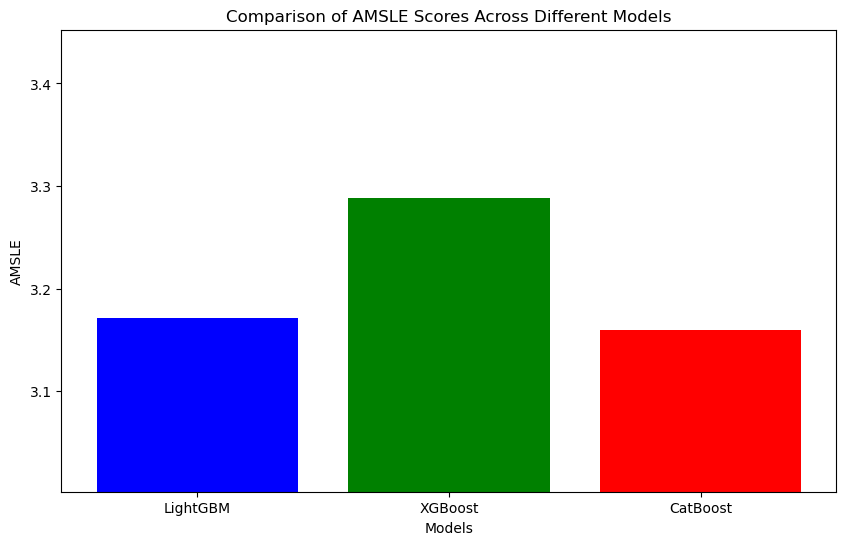

In [30]:
lgbm_amsle = asymmetric_msle_score(target, oof_preds_lgb)
xgboost_amsle = asymmetric_msle_score(target, oof_preds_xgb)
catboost_amsle = asymmetric_msle_score(target, oof_preds_cat)

models = ['LightGBM', 'XGBoost', 'CatBoost']
rmse_scores = [lgbm_amsle, xgboost_amsle, catboost_amsle]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_scores, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('AMSLE')
plt.title('Comparison of AMSLE Scores Across Different Models')
plt.ylim([min(rmse_scores) * 0.95, max(rmse_scores) * 1.05])
plt.show()

Веса были изменены следующим образом:

1. LGBM : 0.6 -> 0.45
2. XGB : 0.3 -> 0.1
3. CAT : 0.1 -> 0.45

Посчитаем конечную ошибку ансамбля на кросс-валидации

In [35]:
cv_score = 0.45 * lgbm_amsle + 0.1 * xgboost_amsle + 0.45 * catboost_amsle
print(f"Ensemle CV score : {cv_score:.3f}")

Ensemle CV score : 3.178


Данный результат сильно лучше чем использование только LGBM

Создадим сабмишн

In [38]:
ss = pd.read_csv("sample_submission.csv").drop(columns='target')
submission = test_df[['fullVisitorId']].copy()
submission.loc[:, 'target'] = final_predictions
grouped_test = submission[['fullVisitorId', 'target']].groupby('fullVisitorId').mean().reset_index()
ss['fullVisitorId'] = ss['fullVisitorId'].astype(str)
result = pd.merge(ss, grouped_test, on='fullVisitorId', how='left')
result['target'] = result['target'].fillna(0)

In [39]:
if result.isnull().values.any():
    print("Submission contains missing values.")
else:
    result.to_csv(f"Babaev_submission_{submission_num}.csv")
    submission_num += 1